# Anlyse Detector=32 (Run 13229)

Let's put the pieces together 

In [1]:
! eups list -s lsst_distrib

   gdf42428520+f51fc98903 	current w_2023_23 setup


In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
from astropy.stats import sigma_clip
from scipy.stats import skew
from matplotlib.patches import Rectangle

import lsst.afw.display as afwDisplay
from astropy.visualization import imshow_norm, MinMaxInterval,AsinhStretch,LinearStretch,SqrtStretch,ContrastBiasStretch,ZScaleInterval,AsymmetricPercentileInterval,ManualInterval

# from myutils import *

In [3]:
import seaborn as sns
sns.set_context('talk')

# Run 12 Jun

In [16]:
from lsst.daf.butler import Butler
repo = '/sdf/group/rubin/repo/main/butler.yaml'
collections = 'u/jesteves/2023.06.15/testRun'
butler = Butler(repo,collections=collections)
registry = butler.registry

In [17]:
### check repo
for dtype in registry.queryDatasetTypes():
    try:
        datasetRefs = list(registry.queryDatasets(datasetType=dtype,collections=collections))
        if len(datasetRefs)>1:
            print(len(datasetRefs), dtype)
    except:
        i=1

6188213 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
378 DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
378 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
378 DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
378 DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
3 DatasetType('packages', {}, Packages)
372 DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
372 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
3 DatasetType('isr_config', {}, Config)
378 DatasetType('linearizer', {instrument, detector}, Linearizer, isCalibration=True)
372 DatasetType('isr_log', {band, instrument, detector, physical_filter, exposure}, ButlerLogRecords)
3 DatasetType('gridFit_config', {}, Config)
3 DatasetType('spotSrc_schema', {}, SourceCatalog)
3 Da

In [19]:
collections

'u/jesteves/2023.06.15/testRun'

## Get gridSpotSrc output

In [193]:
kwargs={
"datasetType": "gridSpotSrc",
"collections": collections,
"where":
"""
instrument='LSSTCam' and
exposure.science_program in ( '13229' ) and
detector in (32,31) and
exposure = 3021122200177
"""
}

_datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(_datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 2 in this repository with the condition supplied {'datasetType': 'gridSpotSrc', 'collections': 'u/jesteves/2023.06.15/testRun', 'where': "\ninstrument='LSSTCam' and\nexposure.science_program in ( '13229' ) and\ndetector in (32,31) and\nexposure = 3021122200177\n"}


In [194]:
nSrcs = np.array([len(butler.get('gridSpotSrc',_datasetRefs[i].dataId).asAstropy()) for i in range(len(_datasetRefs))])
print('Number of sources inside grid spot catalog')
print('A common half grid should have at least 1000 spots')
nSrcs

Number of sources inside grid spot catalog
A common half grid should have at least 1000 spots


array([1135, 1139])

In [195]:
# select only the half-grid images
sel = np.where(np.array(nSrcs)>500)[0]
datasetRefs = [_datasetRefs[i] for i in sel]
print(f'You have {sel.size} spot catalogs with half-grid')

You have 2 spot catalogs with half-grid


## Grid Pairs

In [197]:
exposures = []
detectors = []
for i in range(len(datasetRefs)):
    exposures.append(datasetRefs[i].dataId['exposure'])
    detectors.append(datasetRefs[i].dataId['detector'])
    print(i, datasetRefs[i].dataId['exposure'], datasetRefs[i].dataId['detector'])

0 3021122200177 31
1 3021122200177 32


The images that have same exposure IDs are the grid-pairs!

In [198]:
from collections import Counter
a = np.array(exposures)
pairExpId = [item for item, count in Counter(a).items() if count > 1]
pairs = [np.where(a==expid)[0] for expid in pairExpId]
pairs[0]

array([0, 1])

### Grid Offsets

In [199]:
# help(np.mod)
np.mod([4010,4080],[4000,4072])

array([10,  8])

In [220]:
def get_xy_coord(dataID):
    cat = butler.get('gridSpotSrc',dataID.dataId)
    return cat.getMetadata()['GRID_X0'],cat.getMetadata()['GRID_Y0']

def get_center(dataID):
    center = get_xy_coord(dataID)
    return center

def get_offset(dataID):
    center = np.array(get_xy_coord(dataID))
    center[0] = np.where(center[0]>3000, (center[0]-4072), center[0])
    center[1] = np.where(center[1]>3000, (center[1]-4000), center[1])
    return center

In [221]:
centers = np.array([get_center(dR) for dR in datasetRefs])
centers

array([[4155.08139923, 1994.27928678],
       [ -79.82917778, 1995.31986872]])

In [222]:
offsets = np.array([get_offset(dR) for dR in datasetRefs])
offsets

array([[  83.08139923, 1994.27928678],
       [ -79.82917778, 1995.31986872]])

In [223]:
spacing = []
for pair in pairs:
    spacing.append(offsets[pair[0]] - offsets[pair[1]])

In [224]:
spacing

[array([162.91057701,  -1.04058194])]

In [176]:
# np.mod(spacing,[-4072,-4000])

In [177]:
bots = np.array([get_xy_bot(dR) for dR in datasetRefs])
bots

array([[-148.006, -148.006],
       [-106.01 , -106.01 ],
       [-127.006, -127.006],
       [-127.007, -127.007],
       [-148.006, -148.006],
       [-106.01 , -106.01 ],
       [-127.007, -127.007],
       [-127.007, -127.007]])

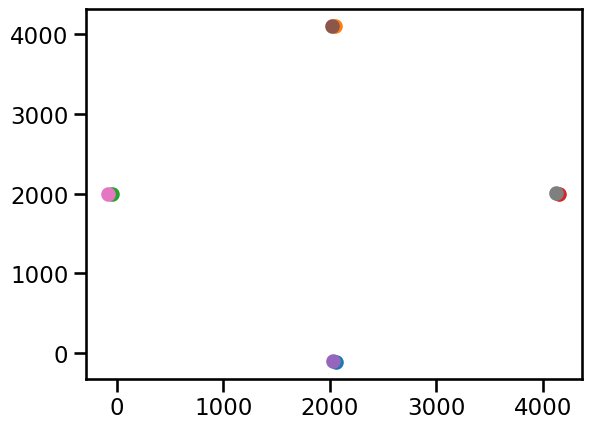

In [53]:
for i in range(8):
    plt.scatter(*centers[i])

In [47]:
cat = butler.get('gridSpotSrc',datasetRefs[0].dataId)
list(cat.getMetadata())

['BASE_CIRCULARAPERTUREFLUX_RADII',
 'NOISE_SEED_MULTIPLIER',
 'NOISE_SOURCE',
 'NOISE_OFFSET',
 'NOISE_EXPOSURE_ID',
 'BOTXCAM',
 'BOTYCAM',
 'GRID_X0',
 'GRID_X0ERR',
 'GRID_Y0',
 'GRID_Y0ERR',
 'GRID_THETA',
 'GRID_THETAERR',
 'GRID_XSTEP',
 'GRID_YSTEP',
 'GRID_NCOLS',
 'GRID_NROWS',
 'FIT_NFEV',
 'FIT_SUCCESS',
 'FIT_NDATA',
 'FIT_CHISQR',
 'FIT_REDCHI']

In [ ]:
def plot_image_cat(dRef, axs=None, vmin=0., vmax=6e3):
    img = butler.get('postISRCCD', dRef.dataId)
    cat = butler.get('gridSpotSrc',dRef.dataId)

    if axs is None: axs = plt.gca()
    x,y=cat.asAstropy()['base_SdssCentroid_x'],cat.asAstropy()['base_SdssCentroid_y']
    axs.scatter(x,y,s=1,color='r',alpha=0.5)
    common={
        "vmin": vmin,
        "vmax": vmax,
        "norm": "asinh"
    }
    p = axs.imshow(img.image.array,cmap="gray",origin="lower",**common)
    axs.set_title('ExpId = %i'%img.visitInfo.getId(), fontsize=12)
    return p

def plot_tier(datalist,detnum=32):
    fig,axs = plt.subplots(nrows=1, ncols=4,figsize=(12,3))
    for i in range(4):
        plot_image_cat(datalist[i], axs=axs[i])
        
    fig.tight_layout()
    fig.suptitle('Detector = %i'%detnum, fontsize=12)

## GridFit

In [23]:
def plot_image_cat(img, cat, axs=None, vmin=-5, vmax=50):
    if axs is None: axs = plt.gca()
    x,y=cat['base_SdssCentroid_x'],cat['base_SdssCentroid_y']
    axs.scatter(x,y,s=1,color='r',alpha=0.5)
    common={
        "vmin": vmin,
        "vmax": vmax
        #"norm": "asinh"
    }
    p = axs.imshow(img.image.array,cmap="gray",origin="lower",**common)
    axs.set_title('ExpId = %i'%img.visitInfo.getId(), fontsize=12)
    return p

def plot_tier(detnum):
    img = imgs['%i'%detnum]
    cat = cats['%i'%detnum]
    
    fig,axs = plt.subplots(nrows=1, ncols=4,figsize=(12,3))
    for i in range(4):
        plot_image_cat(img[i], cat[i], axs=axs[i])
        axs[i].set_title('%i'%i, fontsize=12)
    fig.tight_layout()
    fig.suptitle('Detector = %i'%detnum, fontsize=12)

In [14]:
run13229['%i'%32]

[DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 32, exposure: 3021122200166, ...}, run='u/jesteves/2023.06.12/det32Neighbors/20230613T200521Z', id=f0562a48-2e8a-4aef-952a-6e4631befce8),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 32, exposure: 3021122200178, ...}, run='u/jesteves/2023.06.12/det32Neighbors/20230613T200521Z', id=76edb414-3aa7-4221-b748-637dacbad405),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 32, exposure: 3021122200177, ...}, run='u/jesteves/2023.06.12/det32Neighbors/20230613T200521Z', id=85595b46-1e7b-4b9d-8420-aba933cf9d38),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 32, exposure: 302112220016

In [13]:
run13229['%i'%31][]

[DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 31, exposure: 3021122200168, ...}, run='u/jesteves/2023.06.12/det32Neighbors/20230613T200521Z', id=14d60ac8-e876-42ef-8793-32c96bcaf431),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 31, exposure: 3021122200165, ...}, run='u/jesteves/2023.06.12/det32Neighbors/20230613T200521Z', id=d9577f10-edf9-4429-b4e7-74f841d2bd8d),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 31, exposure: 3021122200176, ...}, run='u/jesteves/2023.06.12/det32Neighbors/20230613T200521Z', id=96c5fb6a-80bf-4232-9cf5-2fd7ea429393),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 31, exposure: 302112220017

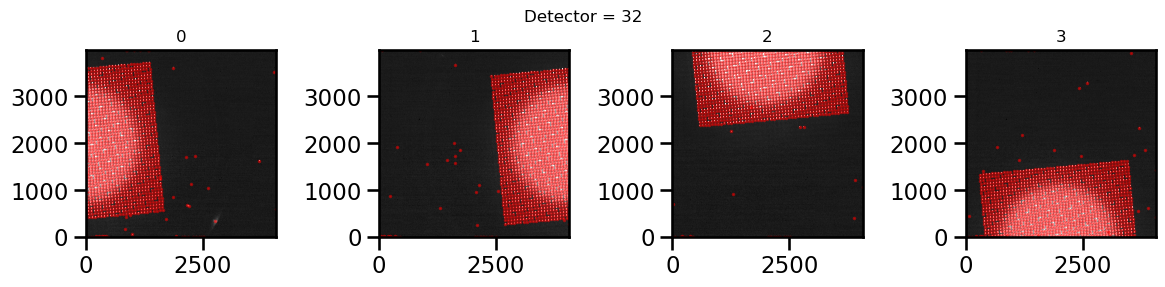

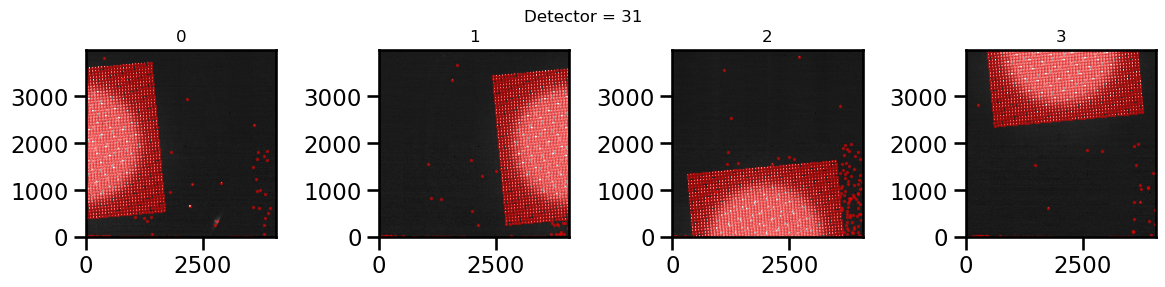

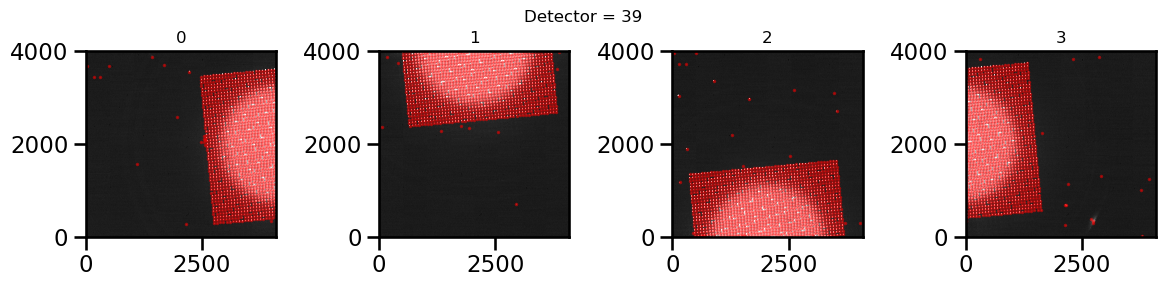

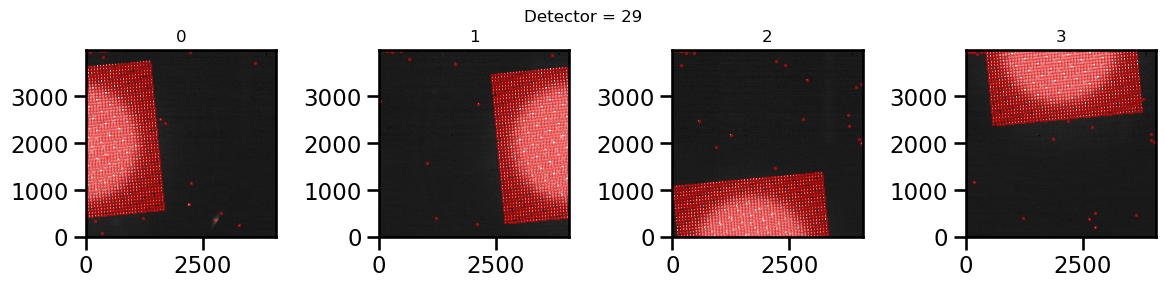

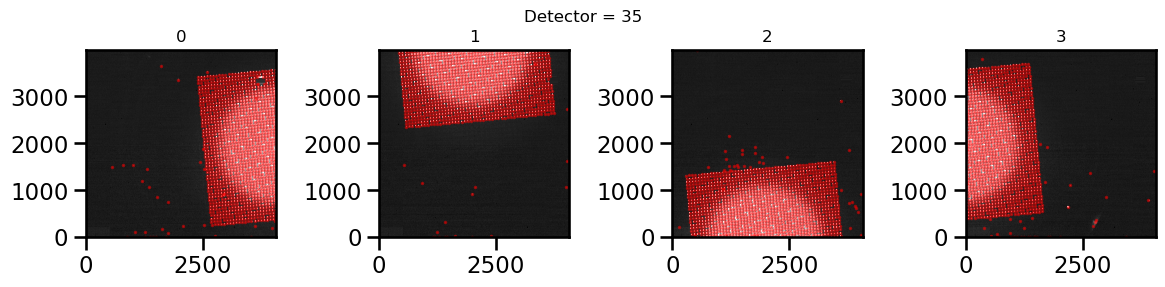

In [66]:
for detnum in [32,31,39,29,35]:
    plot_tier(detnum)

In [ ]:
fig,axs = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
axs = axs.flatten()

for i in range(4):
    img = imgs['%i'%detnum][i]
    cat = cats['%i'%detnum][i]
    plot_image_cat(img, cat, axs=axs[i])

# fig.suptitle('ITL R10-S12')
fig.tight_layout()
# fig.savefig('run13229_det32_array.png',dpi=120)


## Display Images

Check if the sources are well behaved.

Lines based on Yousuke's notebook example: https://github.com/youtsumi/JohnnyPaper/blob/main/ExampleImage.ipynb

### 13229

In [32]:
kwargs={
"datasetType": "postISRCCD",
"collections": collections,
"where":
"""
instrument='LSSTCam' and
exposure.science_program in ( '13229' ) and
detector=32
"""
}

datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 30 in this repository with the condition supplied {'datasetType': 'postISRCCD', 'collections': ['LSSTCam/raw/all', 'LSSTCam/calib', 'u/jesteves/2023.06.12/test_a'], 'where': "\ninstrument='LSSTCam' and\nexposure.science_program in ( '13229' ) and\ndetector=32\n"}


In [48]:
def plot_image_lookup(img, cat, vmin=0., vmax=5e3):
    #vmin,vmax = np.nanpercentile(img.image.array,[5,95])
    x,y=cat.asAstropy()["base_SdssCentroid_x","base_SdssCentroid_y"][120]

    fig,axs = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
    common={
        "vmin": vmin,
        "vmax": vmax,
        "norm": "asinh"
    }
    axs[0].imshow(img.image.array,cmap="gray",origin="lower",**common)


    axs[0].set_title("The whole sensor view")
    w=100
    axs[0].add_patch(Rectangle((x-w+1,y-w+1),2*w+1,2*w+1,color="red",facecolor="none",fill=None))

    p=axs[1].imshow(img[x-w+1:x+w+1,y-w+1:y+w+1].image.array,cmap="gray",origin="lower",**common)
    axs[1].set_xticklabels(np.arange(x-w+1,x+w+1,20).astype(int))
    axs[1].set_yticklabels(np.arange(y-w+1,y+w+1,20).astype(int))
    axs[1].set_title("Close-up")
    for ax in axs:
        ax.set_xlabel("X in pixel")
        ax.set_ylabel("Y in pixel")    

    fig.colorbar(p,label="Flux [e-]")
    #fig.suptitle(raw.getMetadata()["LSST_NUM"])
    fig.tight_layout()


/tmp/ipykernel_15643/3814163450.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].add_patch(Rectangle((x-w+1,y-w+1),2*w+1,2*w+1,color="red",facecolor="none",fill=None))
/tmp/ipykernel_15643/3814163450.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(np.arange(x-w+1,x+w+1,20).astype(int))
/tmp/ipykernel_15643/3814163450.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(np.arange(y-w+1,y+w+1,20).astype(int))


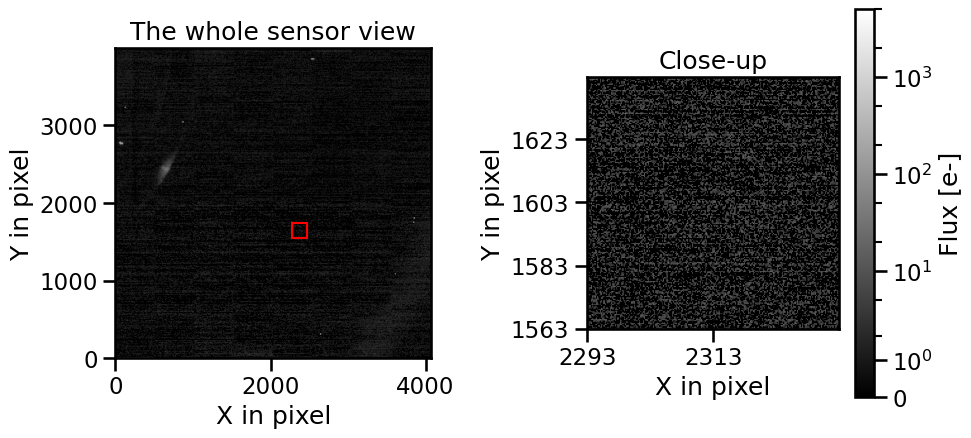

In [49]:
img = butler.get(datasetRefs[4])
cat = butler.get('spotSrc',datasetRefs[4].dataId)
plot_image_lookup(img, cat)

/tmp/ipykernel_15643/3814163450.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].add_patch(Rectangle((x-w+1,y-w+1),2*w+1,2*w+1,color="red",facecolor="none",fill=None))
/tmp/ipykernel_15643/3814163450.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(np.arange(x-w+1,x+w+1,20).astype(int))
/tmp/ipykernel_15643/3814163450.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(np.arange(y-w+1,y+w+1,20).astype(int))


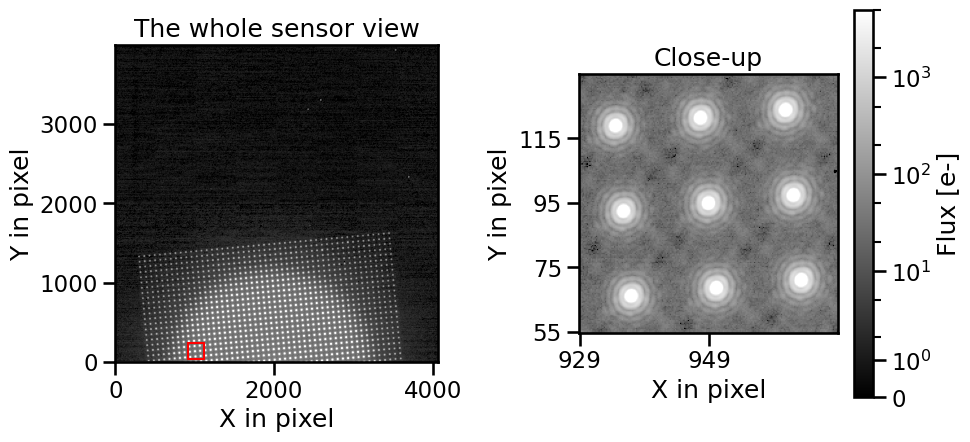

In [50]:
img = butler.get(datasetRefs[2])
cat = butler.get('spotSrc',datasetRefs[2].dataId)
plot_image_lookup(img, cat)

/tmp/ipykernel_15643/3814163450.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].add_patch(Rectangle((x-w+1,y-w+1),2*w+1,2*w+1,color="red",facecolor="none",fill=None))
/tmp/ipykernel_15643/3814163450.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(np.arange(x-w+1,x+w+1,20).astype(int))
/tmp/ipykernel_15643/3814163450.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(np.arange(y-w+1,y+w+1,20).astype(int))


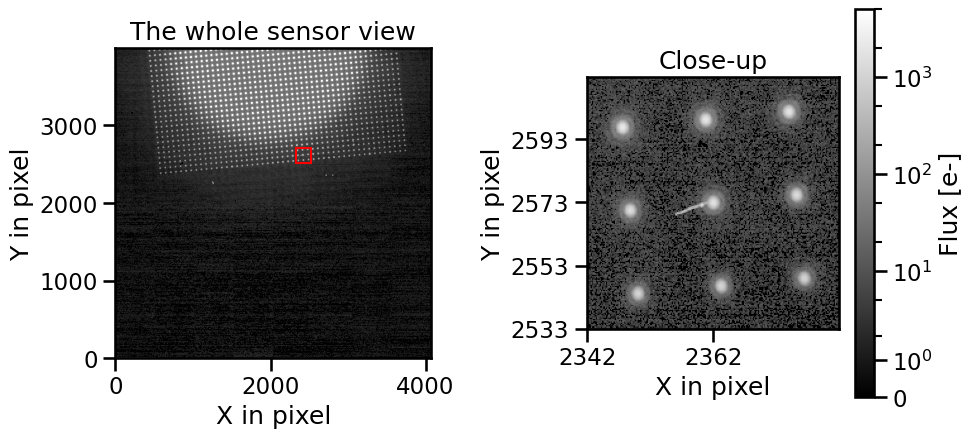

In [51]:
img = butler.get(datasetRefs[5])
cat = butler.get('spotSrc',datasetRefs[5].dataId)
plot_image_lookup(img, cat)

/tmp/ipykernel_12076/977289028.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].add_patch(Rectangle((x-w+1,y-w+1),2*w+1,2*w+1,color="red",facecolor="none",fill=None))
/tmp/ipykernel_12076/977289028.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(np.arange(x-w+1,x+w+1,20).astype(int))
/tmp/ipykernel_12076/977289028.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(np.arange(y-w+1,y+w+1,20).astype(int))


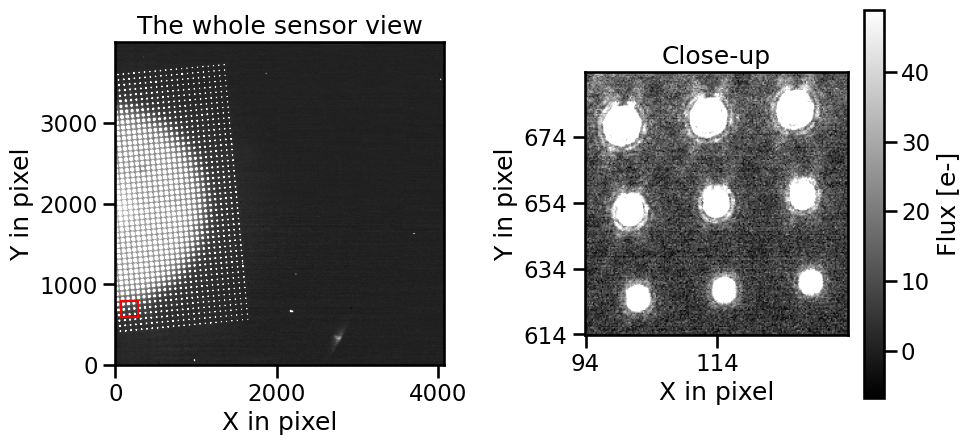

In [300]:
img = butler.get(datasetRefs[13])
cat = butler.get('spotSrc',datasetRefs[13].dataId)
plot_image_lookup(img, cat)

(array([26.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([ 143. ,  250.2,  357.4,  464.6,  571.8,  679. ,  786.2,  893.4,
        1000.6, 1107.8, 1215. ]),
 <BarContainer object of 10 artists>)

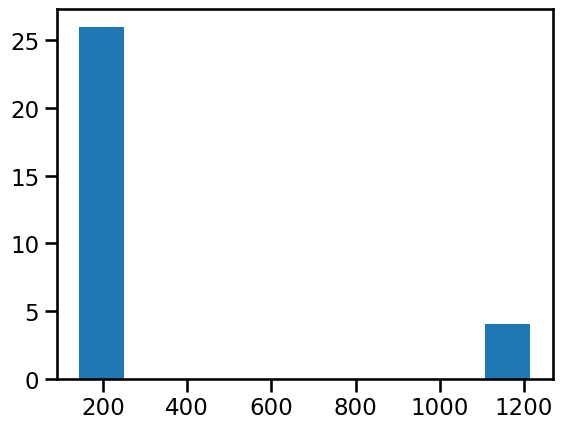

In [301]:
nSrcs = [len(butler.get('spotSrc',datasetRefs[i].dataId).asAstropy()) for i in range(len(datasetRefs))]
plt.hist(nSrcs)

In [302]:
spots = np.where(np.array(nSrcs)>400)[0]
spots

array([ 2,  5, 13, 14])

/tmp/ipykernel_12076/977289028.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].add_patch(Rectangle((x-w+1,y-w+1),2*w+1,2*w+1,color="red",facecolor="none",fill=None))
/tmp/ipykernel_12076/977289028.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(np.arange(x-w+1,x+w+1,20).astype(int))
/tmp/ipykernel_12076/977289028.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(np.arange(y-w+1,y+w+1,20).astype(int))


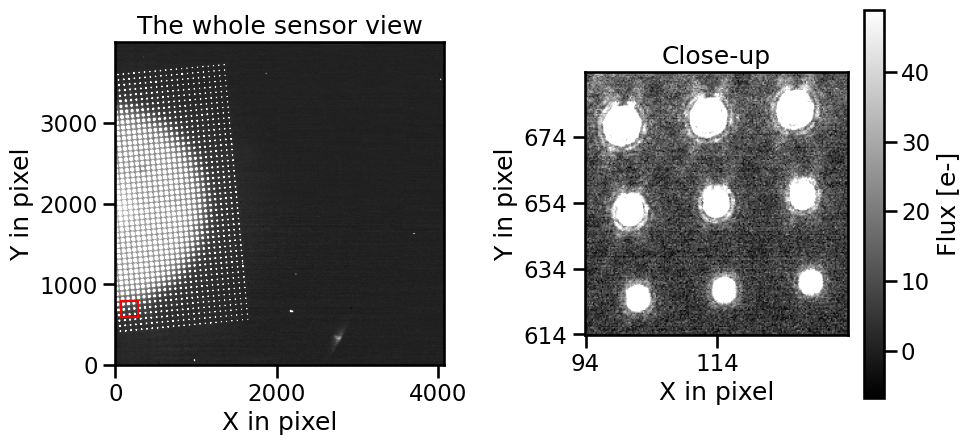

In [303]:
img = butler.get(datasetRefs[13])
cat = butler.get('spotSrc',datasetRefs[13].dataId)
plot_image_lookup(img, cat)

In [304]:
def plot_image_cat(img, cat, axs=None, vmin=-5, vmax=50):
    if axs is None: axs = plt.gca()
    x,y=cat.asAstropy()['base_SdssCentroid_x'],cat.asAstropy()['base_SdssCentroid_y']
    axs.scatter(x,y,s=1,color='r',alpha=0.5)
    common={
        "vmin": vmin,
        "vmax": vmax
        #"norm": "asinh"
    }
    p = axs.imshow(img.image.array,cmap="gray",origin="lower",**common)
    axs.set_title('ExpId = %i'%img.visitInfo.getId(), fontsize=12)
    return p

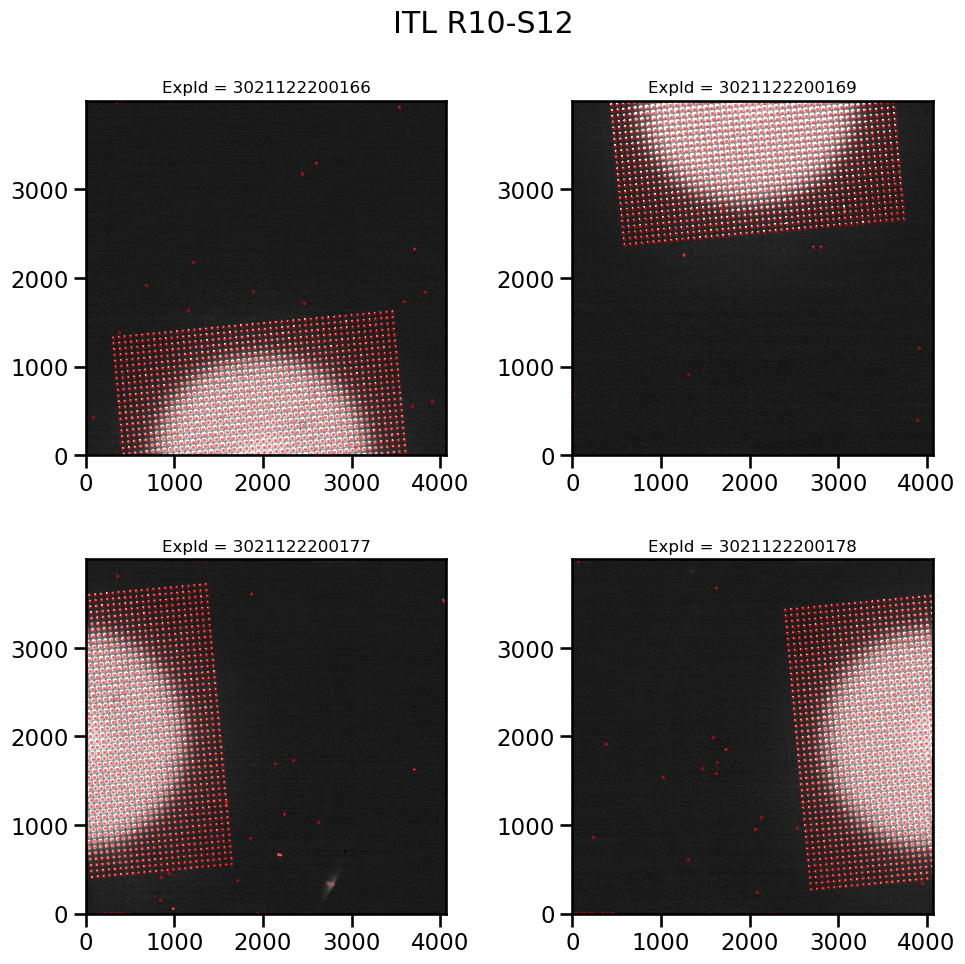

In [305]:
fig,axs = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
axs = axs.flatten()
for i,si in enumerate(spots):
    img = butler.get(datasetRefs[si])
    cat = butler.get('spotSrc',datasetRefs[si].dataId)
    plot_image_cat(img, cat, axs=axs[i])

fig.suptitle('ITL R10-S12')
fig.tight_layout()
fig.savefig('run13229_det32_array.png',dpi=120)

### Other Detector

In [291]:
kwargs={
"datasetType": "postISRCCD",
"collections": collections,
"where":
"""
instrument='LSSTCam' and
exposure.science_program in ( '13229' ) and
detector=166
"""
}

datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 29 in this repository with the condition supplied {'datasetType': 'postISRCCD', 'collections': ['LSSTCam/raw/all', 'LSSTCam/calib', 'u/jesteves/2023.06.12/test_a'], 'where': "\ninstrument='LSSTCam' and\nexposure.science_program in ( '13229' ) and\ndetector=166\n"}


(array([23.,  0.,  0.,  0.,  1.,  1.,  0.,  3.,  0.,  1.]),
 array([  31. ,  187.6,  344.2,  500.8,  657.4,  814. ,  970.6, 1127.2,
        1283.8, 1440.4, 1597. ]),
 <BarContainer object of 10 artists>)

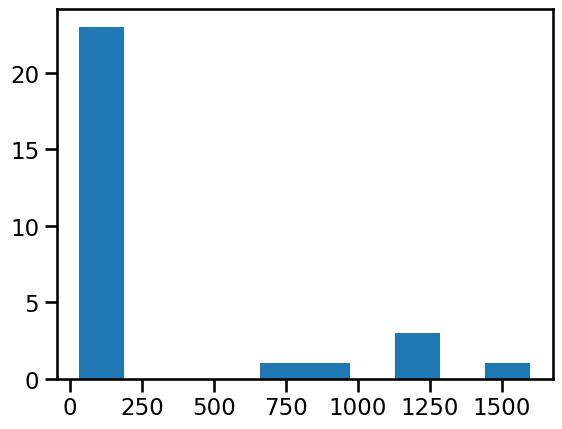

In [292]:
nSrcs = [len(butler.get('spotSrc',datasetRefs[i].dataId).asAstropy()) for i in range(len(datasetRefs))]
plt.hist(nSrcs)

In [293]:
spots=np.where(np.array(nSrcs)>500)[0]
spots

array([ 7, 10, 15, 16, 18, 19])

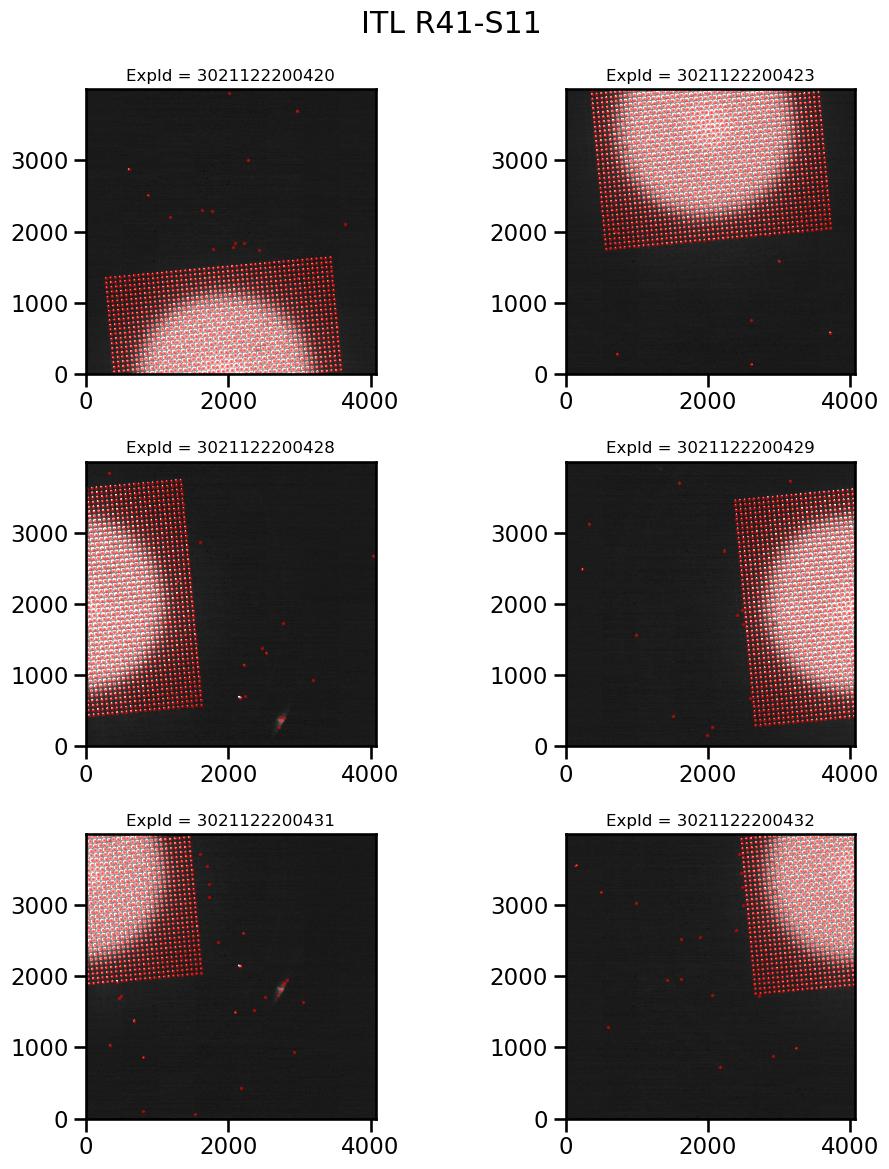

In [294]:
fig,axs = plt.subplots(nrows=3, ncols=2,figsize=(10,12))
axs = axs.flatten()
for i,si in enumerate(spots):
    img = butler.get(datasetRefs[si])
    cat = butler.get('spotSrc',datasetRefs[si].dataId)
    plot_image_cat(img, cat, axs=axs[i])

fig.suptitle('ITL R41-S11')
fig.tight_layout()
fig.savefig('run13229_det166_array.png',dpi=120)